In [2]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 99

In [3]:
cols =  ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [4]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
cars = cars.replace('?', np.nan)

In [6]:
# Selecting only the columns with continuous values from - https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

In [7]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [8]:
# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [9]:
# Replace missing values in other columns using column means.# Replac 
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [10]:
# Confirm that there's no more missing values!
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [11]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

# Univariate Model

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(42)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
      
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

width                4169.982920
horsepower           4350.979936
city-mpg             4413.500971
curb-weight          4625.061230
highway-mpg          4914.877070
wheel-base           5096.723829
length               5357.692657
compression-rate     5914.076632
stroke               6551.795999
bore                 6676.712709
peak-rpm             6979.403412
height               7053.377644
normalized-losses    8464.431929
dtype: float64

In [13]:
def  knn_train_test_k(train_col, target_col, df, k_values):
    np.random.seed(42)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]

    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
k_values = [1,3,5,7,9]
for col in train_cols:
    rmse_val = knn_train_test_k(col, 'price', numeric_cars, k_values)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 7731.5802734468507,
  3: 7025.2713600307434,
  5: 6676.7127090513577,
  7: 6082.4653044164734,
  9: 6126.4197515358273},
 'city-mpg': {1: 6046.8926239797402,
  3: 4798.8170879232657,
  5: 4413.5009712211795,
  7: 4655.9360382636805,
  9: 4782.064381423028},
 'compression-rate': {1: 7393.1810085877496,
  3: 6927.310859386509,
  5: 5914.0766316266545,
  7: 5636.0406024853291,
  9: 5627.9594797761038},
 'curb-weight': {1: 5532.6991300238205,
  3: 4726.8452217388112,
  5: 4625.0612299719987,
  7: 4670.8563918211803,
  9: 4490.2865434886644},
 'height': {1: 8542.8044407484413,
  3: 7235.3315790919996,
  5: 7053.3776436372937,
  7: 6783.2661653866189,
  9: 6836.8059776776427},
 'highway-mpg': {1: 5749.0368655269658,
  3: 4461.9986243691719,
  5: 4914.8770702675347,
  7: 4083.7289788131707,
  9: 4431.2806658673207},
 'horsepower': {1: 4824.7711031736835,
  3: 4643.1017991028029,
  5: 4350.9799363288994,
  7: 4444.2034745652736,
  9: 4308.9843403462237},
 'length': {1: 5953.280443

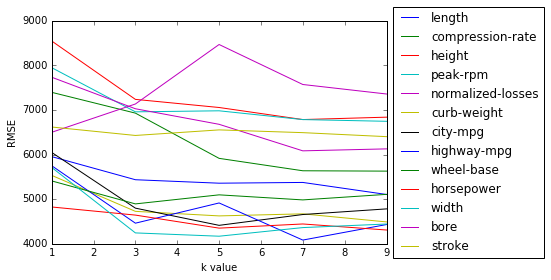

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

for k, v in k_rmse_results.items():
    x_ = list(v.keys())
    y_ = list(v.values())
    x = sorted(x_)
    y = [y for x,y in sorted(zip(x_,y_))]
    
    plt.plot(x,y, label=k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Multivariate Model

In [15]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
series_avg_rmse.sort_values()

horsepower           4514.408131
width                4586.217807
highway-mpg          4728.184441
curb-weight          4809.149703
city-mpg             4939.442221
wheel-base           5098.054676
length               5445.185461
compression-rate     6299.713716
stroke               6497.106722
bore                 6728.489880
peak-rpm             7081.678926
height               7290.317161
normalized-losses    7403.739961
dtype: float64

In [16]:
def  knn_train_test_k(train_cols, target_col, df, k_values):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]

    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses


k_rmse_results = {}
k_values = [5]

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test_k(two_best_features, 'price', numeric_cars, k_values)
k_rmse_results[2] = rmse_val[5]

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test_k(three_best_features, 'price', numeric_cars, k_values)
k_rmse_results[3] = rmse_val[5]

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test_k(four_best_features, 'price', numeric_cars, k_values)
k_rmse_results[4] = rmse_val[5]

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test_k(five_best_features, 'price', numeric_cars, k_values)
k_rmse_results[5] = rmse_val[5]

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test_k(six_best_features, 'price', numeric_cars, k_values)
k_rmse_results[6] = rmse_val[5]

k_rmse_results

{2: 3589.3132622073304,
 3: 3305.9401397969677,
 4: 3280.3807311630976,
 5: 3341.6024539726504,
 6: 3628.2611882141268}

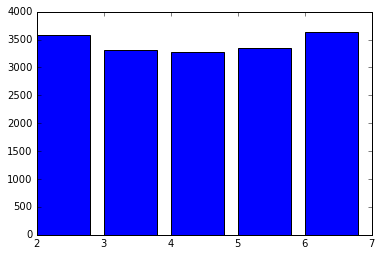

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(list(k_rmse_results.keys()), list(k_rmse_results.values()))
plt.show()

In [28]:
k_values = [i for i in range(1, 35)]
knn_train_test_k(six_best_features, 'price', numeric_cars, k_values)

k_rmse_results = {}

rmse_val = knn_train_test_k(three_best_features, 'price', numeric_cars, k_values)
k_rmse_results["three best features"] = rmse_val

rmse_val = knn_train_test_k(four_best_features, 'price', numeric_cars, k_values)
k_rmse_results["four best features"] = rmse_val

rmse_val = knn_train_test_k(five_best_features, 'price', numeric_cars, k_values)
k_rmse_results["five best features"] = rmse_val

k_rmse_results


{'five best features': {1: 2530.0554077602005,
  2: 2897.1757974767684,
  3: 3183.4597426217424,
  4: 3168.0230415758415,
  5: 3341.6024539726504,
  6: 3537.5205429981911,
  7: 3817.2904521188252,
  8: 4004.4145296855731,
  9: 3992.3186041830318,
  10: 4138.7287878533352,
  11: 4342.0528528290979,
  12: 4416.1453810311359,
  13: 4493.8798141857205,
  14: 4463.5016015545707,
  15: 4474.480783207805,
  16: 4553.5595362768345,
  17: 4597.001081375769,
  18: 4655.283442648355,
  19: 4687.9008939828218,
  20: 4712.0229855431653,
  21: 4755.8566258237734,
  22: 4788.162720030673,
  23: 4806.9233819650544,
  24: 4879.983352195467,
  25: 4923.8448430324688,
  26: 4938.5853154219867,
  27: 4989.9916401911842,
  28: 5033.09403870597,
  29: 5069.0263300073066,
  30: 5125.5504734984943,
  31: 5176.6556569305203,
  32: 5183.0580829185519,
  33: 5155.3537470282708,
  34: 5185.7437806416738},
 'four best features': {1: 2516.5892799502258,
  2: 2811.1727257604443,
  3: 3013.3615157930335,
  4: 3126.26

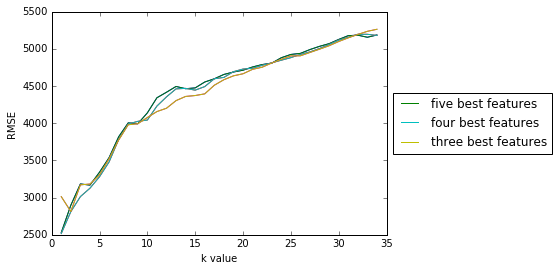

In [27]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.plot(x,y, label=k)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Interistringly, the difference once you add an extra parameter is not big. Except for the minimal k.